# Python Assignment CS253

## Importing Libraries

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

## Importing Training and Testing Data

In [17]:
rawdata = pd.read_csv('train.csv')
data = pd.DataFrame(rawdata)

rawtestdata = pd.read_csv('test.csv')
testdata = pd.DataFrame(rawtestdata)
print(data.head())

   ID             Candidate        Constituency ∇ Party  Criminal Case  \
0   0            M.K. Mohan            ANNA NAGAR   DMK              4   
1   1  Khatik Ramesh Prasad           KARERA (SC)   BJP              0   
2   2      Dr. Mantar Gowda              MADIKERI   INC              0   
3   3          Kundan Kumar             BEGUSARAI   BJP              0   
4   4       Swapan Majumder  BANGAON DAKSHIN (SC)   BJP              2   

  Total Assets Liabilities           state      Education  
0   211 Crore+    2 Crore+      TAMIL NADU       8th Pass  
1     1 Crore+           0  MADHYA PRADESH      12th Pass  
2     7 Crore+     22 Lac+       KARNATAKA  Post Graduate  
3     9 Crore+     24 Lac+           BIHAR  Post Graduate  
4     2 Crore+     61 Lac+     WEST BENGAL       8th Pass  


## Manipulating Data to Apply ML

##### Converting Total Assets and Liabilites in Lakkhs (dtyoe = float) 

In [18]:
def convert_to_lakhs(amount):
    if amount == '0':
        return 0
    amount = amount.split(' ')
    if amount[1] == 'Lac+':
        return int(amount[0])
    elif amount[1] == 'Crore+':
        return int(amount[0])*100

In [19]:
data['Total Assets'] = data['Total Assets'].apply(convert_to_lakhs)
data['Liabilities'] = data['Liabilities'].apply(convert_to_lakhs)
testdata['Total Assets'] = testdata['Total Assets'].apply(convert_to_lakhs)
testdata['Liabilities'] = testdata['Liabilities'].apply(convert_to_lakhs)

##### Filling the empty values if any with mean of that respective column

In [20]:
imputer = SimpleImputer(strategy='mean')
data[['Total Assets', 'Liabilities']] = imputer.fit_transform(data[['Total Assets', 'Liabilities']])
testdata[['Total Assets', 'Liabilities']] = imputer.transform(testdata[['Total Assets', 'Liabilities']])

##### Using the LabelEncoder() to convert the label into dtype=int to use numpy arrays

In [21]:
label_encoder = LabelEncoder()
data_state_encoded = label_encoder.fit_transform(np.array(data['state']))
testdata_state_encoded = label_encoder.fit_transform(np.array(testdata['state']))
data_party_encoded = label_encoder.fit_transform(np.array(data['Party']))
testdata_party_encoded = label_encoder.fit_transform(np.array(testdata['Party']))
data_name_encoded = label_encoder.fit_transform(np.array(data['Candidate']))
testdata_name_encoded = label_encoder.fit_transform(np.array(testdata['Candidate']))
data_consistuency_encoded = label_encoder.fit_transform(np.array(data['Constituency ∇']))
testdata_consistuency_encoded = label_encoder.fit_transform(np.array(testdata['Constituency ∇']))

##### Defining the feauture of the model as X_train and target variable as y_train using numpy

In [22]:
X_train = np.array([
    data['Criminal Case'],
    data_party_encoded,
    data_state_encoded,
    data_name_encoded,
]).transpose()

y_train = label_encoder.fit_transform(np.array(data['Education']))

## Training the GradientBoostingClassifier ML Model

In [23]:
gb_classifier = GradientBoostingClassifier(n_estimators=500, random_state=100)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=500, random_state=100)

## Predicing the education level using the Trained Model

In [24]:
X_test = np.array([
    testdata['Criminal Case'],
    testdata_party_encoded,
    testdata_state_encoded,
    testdata_name_encoded,
]).transpose()

y_pred = gb_classifier.predict(X_test)

##### Decoding the y_pred back to Education label from dtype=int to dtype = string

In [25]:
predicted_education = label_encoder.inverse_transform(y_pred)

### Writing predicted Education level to output.csv

In [26]:
ids = testdata['ID']
output_df = pd.DataFrame({'ID': ids, 'Education': predicted_education})
output_df.to_csv('output.csv', index=False)

## Data Visualisation

### Percentage criminal cases of the total criminal cases across political parties

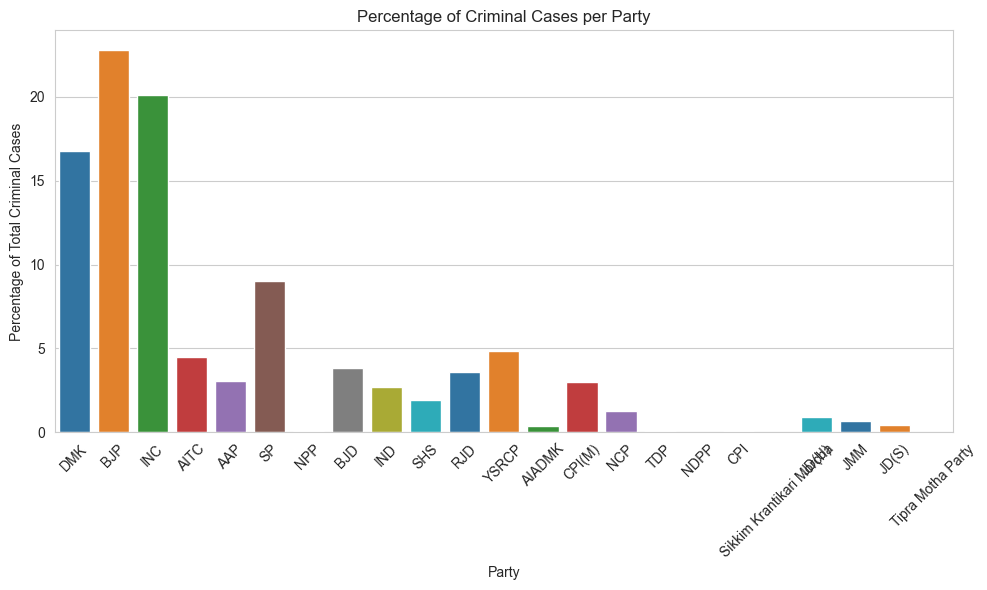

In [27]:
def percentage_criminal_case():
    party_criminal_cases = {}
    totalCriminalCases = float(np.sum(np.array(data['Criminal Case'])))

    for party,cases in zip(data['Party'],data['Criminal Case']):
        if party in party_criminal_cases:
            party_criminal_cases[party] += (cases/totalCriminalCases)*100
        else :
            party_criminal_cases[party] = (cases/totalCriminalCases)*100

    # Plotting
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("pastel", 23)
    sns.barplot(x=list(party_criminal_cases.keys()), y=list(party_criminal_cases.values()),hue=colors[:23],legend=False)
    
    plt.xlabel('Party')
    plt.ylabel('Percentage of Total Criminal Cases')
    plt.title('Percentage of Criminal Cases per Party')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

percentage_criminal_case()

### Percentage of candidate having criminal cases of the total candidate in a paricticular political party

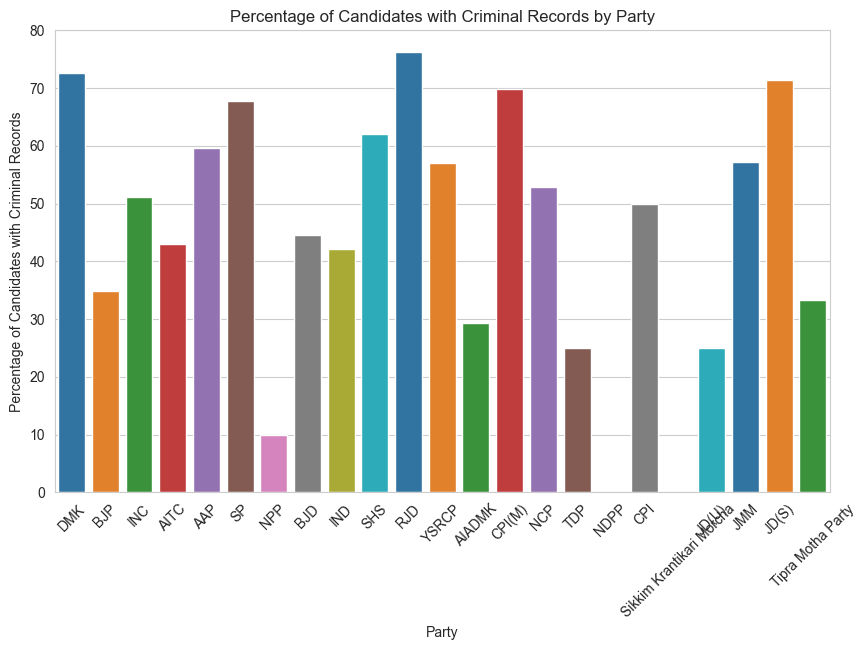

In [28]:
def percentage_candidate_with_criminal_records():
    record = {}
    for party in data['Party'].unique():
        record[party] = {
            'ncandidates' : 0,
            'ncandidate_having_cases' : 0
        }
    for party,cases in zip(data['Party'],data['Criminal Case']):
        record[party]['ncandidates'] += 1
        if cases>0:
            record[party]['ncandidate_having_cases']+=1
    for key,value in record.items():
        record[key]['percentage_candidate_having_cases'] = (
            record[key]['ncandidate_having_cases']/
            record[key]['ncandidates']
        )*100
    parties = list(record.keys())
    percentages = [record[party]['percentage_candidate_having_cases'] for party in parties]

    # List of 10 random colors
    colors = sns.color_palette("pastel", 23)

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    sns.barplot(x=parties, y=percentages, hue=colors[:len(parties)], legend= False)  # Selecting colors for each bar

    plt.xlabel('Party')
    plt.ylabel('Percentage of Candidates with Criminal Records')
    plt.title('Percentage of Candidates with Criminal Records by Party')
    plt.xticks(rotation=45)
    plt.show()
    
percentage_candidate_with_criminal_records()

### Average criminal case per candidate state basis

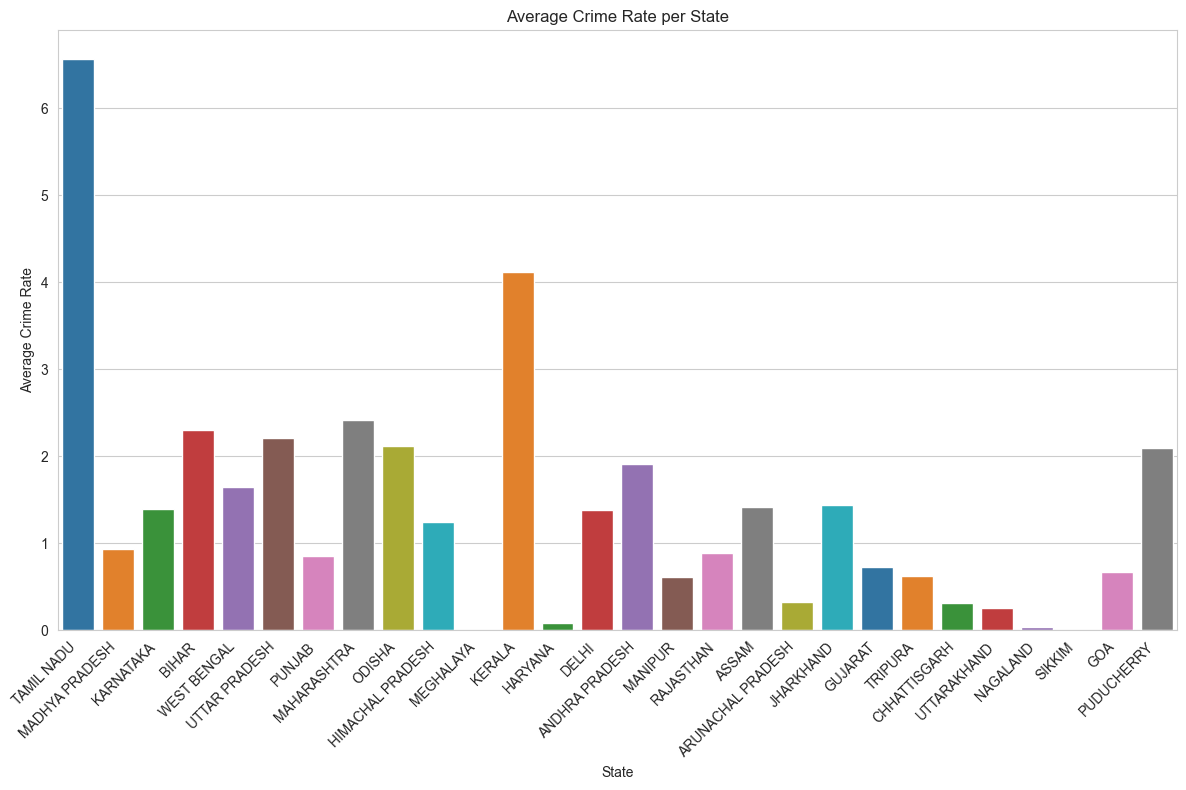

In [29]:
def average_crimecase_percandidate():
    statewise_candidate_ciminalrecord = {}
    for state,cases in zip(data['state'],data['Criminal Case']):
        if state in statewise_candidate_ciminalrecord:
            statewise_candidate_ciminalrecord[state] = {
                "ncandidates": statewise_candidate_ciminalrecord[state]["ncandidates"]+1,
                "cases": statewise_candidate_ciminalrecord[state]["cases"]+cases
            }
        else:
            statewise_candidate_ciminalrecord[state] = {
                "ncandidates": 1,
                "cases": cases
            }
    for key,value in statewise_candidate_ciminalrecord.items():
        statewise_candidate_ciminalrecord[key]["averagecase"]= (
            statewise_candidate_ciminalrecord[key]["cases"]/statewise_candidate_ciminalrecord[key]["ncandidates"]
        )
    df = pd.DataFrame(statewise_candidate_ciminalrecord).transpose()

    plt.figure(figsize=(12, 8))
    sns.set_style('whitegrid')

    # Use a color palette with different colors for each state
    colors = sns.color_palette("pastel", len(df))

    sns.barplot(data=df, x=df.index, y='averagecase', hue=colors,legend=False)

    plt.xlabel('State')
    plt.ylabel('Average Crime Rate')
    plt.title('Average Crime Rate per State')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

average_crimecase_percandidate()

### Percentage wealth distribution across parties

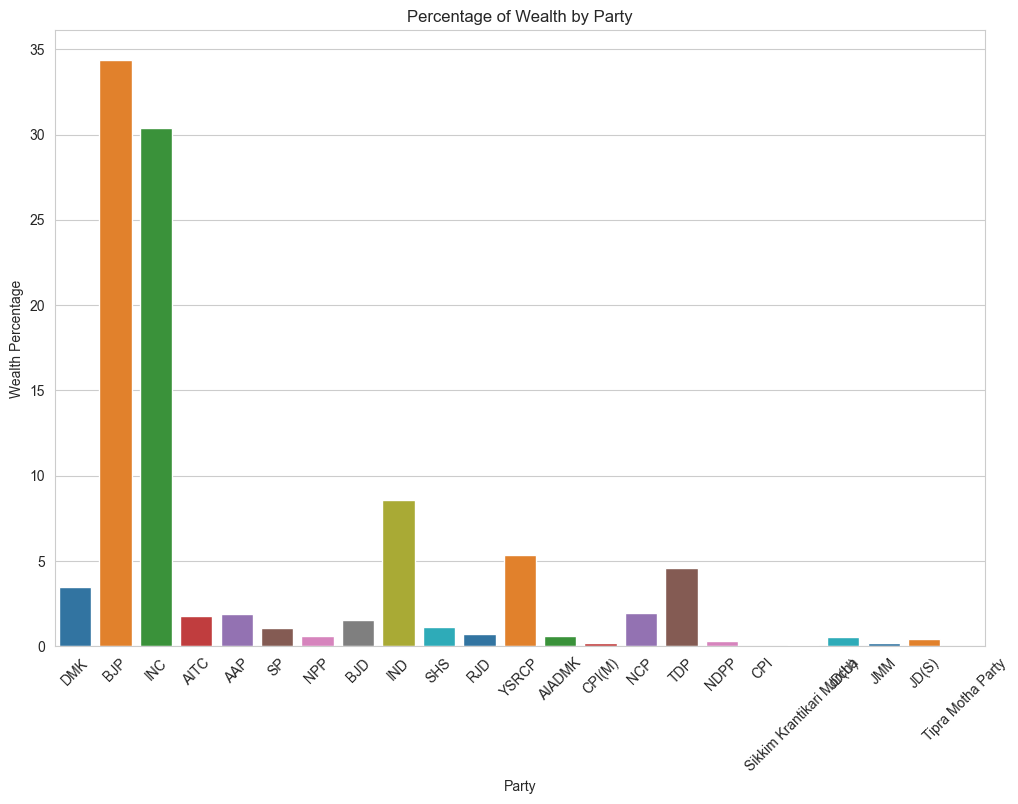

In [30]:
def percentage_parties_wealth():
    totalwealth = np.sum(data['Total Assets'])
    partiesswealth = {}
    for party in data['Party'].unique():
        partiesswealth[party] = 0
    for party, wealth in zip(data['Party'], data['Total Assets']):
        if wealth == 0 or pd.isnull(wealth):
            continue
        partiesswealth[party] += (wealth / totalwealth) * 100
    
    plt.figure(figsize=(12, 8))
    sns.set_style('whitegrid')
    
    colors = sns.color_palette("pastel", len(partiesswealth))
    sns.barplot(y=list(partiesswealth.values()), x=list(partiesswealth.keys()), hue=colors,legend=False)
    plt.ylabel('Wealth Percentage')
    plt.xlabel('Party')
    plt.title('Percentage of Wealth by Party')
    plt.xticks(rotation=45)  
    plt.show()

percentage_parties_wealth()

### Parities wise education level of candidates

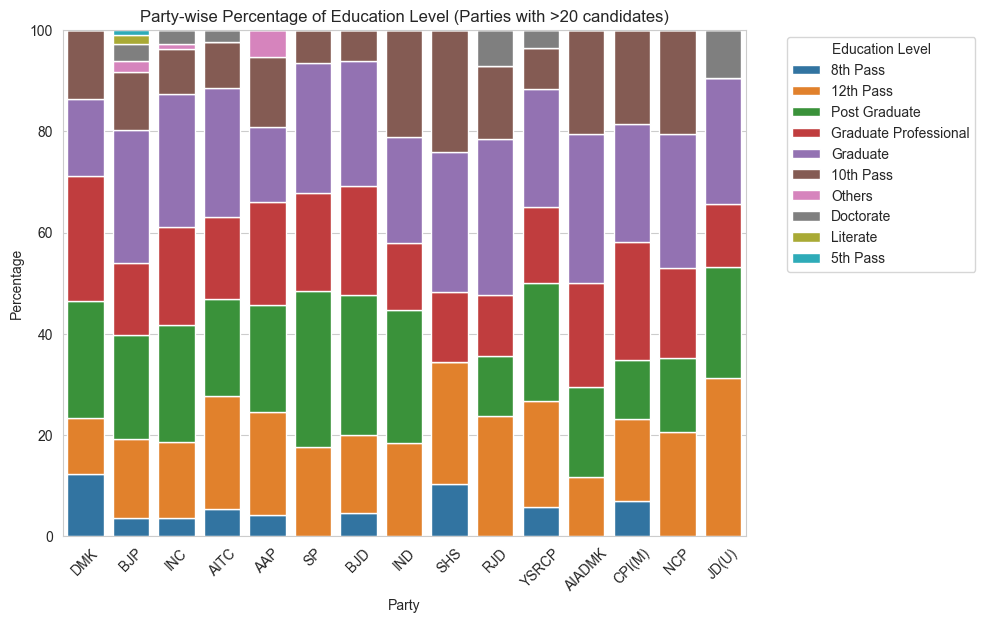

In [31]:
def partywise_percentage_education_level(data):
    partywise_education_level = {}
    education_levels = data['Education'].unique()
    for party in data['Party'].unique():
        partywise_education_level[party] = {"ncandidate": 0}
        for level in education_levels:
            partywise_education_level[party][level] = 0

    for party, education in zip(data['Party'], data['Education']):
        partywise_education_level[party]["ncandidate"] += 1
        partywise_education_level[party][education] +=1
    for party, data in partywise_education_level.items():
        total_candidates = data["ncandidate"]
        for level in education_levels:
            if level != "ncandidate":
                partywise_education_level[party][level] = (partywise_education_level[party][level] / total_candidates) * 100

    filtered_parties = {party: data for party, data in partywise_education_level.items() if data['ncandidate'] > 20}

    parties = list(filtered_parties.keys())
    education_levels = [level for level in partywise_education_level['DMK'].keys() if level != 'ncandidate']

    # Create DataFrame for plotting
    plot_data = []
    for party, data in filtered_parties.items():
        temp = {'Party': party}
        for level in education_levels:
            if level != 'ncandidate':
                temp[level] = data[level]
        plot_data.append(temp)

    df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 6))
    sns.set_style('whitegrid')

    sns.barplot(data=df, x='Party', y=education_levels[0], color=sns.color_palette()[0], label=education_levels[0])
    bottom = df[education_levels[0]]
    for i in range(1, len(education_levels)):
        sns.barplot(data=df, x='Party', y=education_levels[i], bottom=bottom, color=sns.color_palette()[i],
                    label=education_levels[i])
        bottom += df[education_levels[i]]

    plt.xlabel('Party')
    plt.ylabel('Percentage')
    plt.title('Party-wise Percentage of Education Level (Parties with >20 candidates)')
    plt.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

partywise_percentage_education_level(data)

## Report By
#### Mohd Nasar Siddiqui         220661